In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd

In [33]:
df_ny = pd.read_csv('./data/listings.csv.gz', compression='gzip')

In [34]:
columns = list(df_ny.columns)
df_ny.head(1)[columns[10:20]]

,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url
0,https://www.airbnb.com/users/show/3013025,Suada,2012-07-21,"New York, NY",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/cd148...


- number_of_reviews: The number of reviews the listing has
- number_of_reviews_ltm: The number of reviews the listing has (in the last 12 months)
- number_of_reviews_l30d: The number of reviews the listing has (in the last 30 days)
- first_review: The date of the first/oldest review
- last_review	date: The date of the last/newest review
- license	text: The licence/permit/registration number
- instant_bookable: Whether the guest can automatically book the listing without the host requiring to accept their booking request. An indicator of a commercial listing.
- calculated_host_listings_count: The number of listings the host has in the current scrape, in the city/region geography.
- calculated_host_listings_count_entire_homes: The number of Entire home/apt listings the host has in the current scrape, in the city/region geography
- calculated_host_listings_count_private_rooms: The number of Private room listings the host has in the current scrape, in the city/region geography
- calculated_host_listings_count_shared_rooms	integer: The number of Shared room listings the host has in the - current scrape, in the city/region geography
- reviews_per_month: The number of reviews the listing has over the lifetime of the listing

In [35]:
cols = [ 'host_since', 
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 
        'host_identity_verified',
      'neighbourhood_group_cleansed', 
      'property_type', 'room_type', 'accommodates', 
      "bathrooms",    'bathrooms_text', 
      'bedrooms', 'beds', 'amenities', 'price',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
      'first_review',  'last_review', 
      'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']

# Preprocessing

In [36]:
dfi = df_ny[cols].copy()

## Null review per month

## host_neighbourhood

We keep only the locations that are present at list X percent. The others are mapped to "other".

In [37]:
def aggregate_not_frequent(df, column_name, replace_value="other", perc=0.01, replace_nan=True):
    """
    Set to replace_value the values that are less frequent than perc in the column column_name
    Args:
    df: pd.DataFrame
    column_name: str
    replace_value: str, default="other"
    perc: float
    replace_nan: bool, default=True

    Returns:
    pd.DataFrame
    """
    replace_values = [k for k,v in dict(df[column_name].value_counts()).items() if v/len(df)<perc]

    df.loc[df[column_name].isin(replace_values), column_name] = replace_value

    if replace_nan:
        df.loc[df[column_name].isnull(),column_name]=replace_value
    return df

In [38]:
dfi = aggregate_not_frequent(dfi, "host_neighbourhood")

## host_response_time

We set the NaN columsn to "NA" (str)

In [39]:
column_name = "host_response_time"

print(dfi[column_name].value_counts())
print(dfi[column_name].isnull().sum())

dfi.loc[dfi[column_name].isnull(),column_name] = "NA"

host_response_time
within an hour        13951
within a few hours     4988
within a day           2356
a few days or more     1349
Name: count, dtype: int64
14897


## property_type

In [40]:
column_name = "property_type"
print(dfi[column_name].value_counts())
dfi = aggregate_not_frequent(dfi, column_name)
print(dfi[column_name].value_counts())

property_type
Entire rental unit             15623
Private room in rental unit    10520
Private room in home            2483
Entire home                     1330
Room in hotel                   1225
                               ...  
Castle                             1
Private room in ranch              1
Shared room in floor               1
Shared room in guest suite         1
Barn                               1
Name: count, Length: 78, dtype: int64
property_type
Entire rental unit             15623
Private room in rental unit    10520
other                           2621
Private room in home            2483
Entire home                     1330
Room in hotel                   1225
Entire condo                    1138
Private room in townhouse       1125
Private room in condo            508
Entire loft                      496
Entire townhouse                 472
Name: count, dtype: int64


In [41]:
column_name = "room_type"
print(dfi[column_name].value_counts())

room_type
Entire home/apt    19927
Private room       16659
Hotel room           539
Shared room          416
Name: count, dtype: int64


From the column amenities we derive a new column that is the number of available amenities

In [42]:
import ast
dfi["#amenities"] = dfi ["amenities"].apply(lambda x: len(ast.literal_eval(x)))
dfi.drop(columns="amenities", inplace=True)

## first_review

Convert in years since the date of the first review and since the last review

In [43]:
def year_since_review(dfi, column_name):
    """
    Add a column with the years since the review
    Args:
    dfi: pd.DataFrame
    column_name: str
    Returns:
    pd.DataFrame
    """
    dfi[f"{column_name}_year"] = pd.to_datetime("today").year-pd.to_datetime(dfi[column_name],format='%Y-%m-%d').dt.year
    dfi.drop(columns=column_name, inplace=True)
    dfi[f"{column_name}_year"] = dfi[f"{column_name}_year"]
    return dfi

In [46]:
dfi['last_review'].isnull().sum(), dfi['last_review'].shape

(np.int64(11540), (37541,))

In [47]:
dfi = year_since_review(dfi, "first_review")
dfi = year_since_review(dfi, "last_review")
dfi = year_since_review(dfi, "host_since")

In [48]:
dfi['last_review_year'].isnull().sum(), dfi['last_review_year'].shape

(np.int64(11540), (37541,))

In [49]:
dfi['last_review_year'].value_counts()  

last_review_year
1.0     10149
2.0      6496
6.0      1690
3.0      1520
5.0      1475
7.0      1105
9.0      1065
8.0       959
4.0       784
10.0      621
11.0       99
12.0       25
13.0       11
14.0        2
Name: count, dtype: int64

## bathrooms

We drop the column "bathrooms_text" since there is the column "bathrooms" that is numerical.
We first create a column that is 1 the bathroom is shared

In [15]:
dfi['shared_bathroom'] = dfi['bathrooms_text'].apply(lambda x: 1 if type(x)==str and 'shared' in x else 0)
dfi.drop(columns="bathrooms_text", inplace=True)

## Continuous attributes

## Price
Convert price to float, remove currency


In [16]:
column_name="price"
dfi[column_name] = dfi[column_name].str.replace("$", "")
dfi[column_name] = dfi[column_name].str.replace(",", "").astype(float)

### host_response_rate, host_acceptance_rate

In [17]:
column_name = "host_response_rate"
dfi[column_name] = dfi[column_name].str.replace("%", "").astype(float)

column_name = "host_acceptance_rate"
dfi[column_name] = dfi[column_name].str.replace("%", "").astype(float)

# Discretize

We consider review_scores_rating as our target columns.

In [18]:
target_col =  "review_scores_rating"

In [19]:
from utils import discretize
attributes = dfi.columns.drop(target_col)
df_discretized = discretize(dfi, attributes=attributes, bins=3)

Could not discretize 'number_of_reviews_l30d' with 3. We decrease the number of bins to 2
Could not discretize 'number_of_reviews_l30d' with 2. We decrease the number of bins to 1


In [20]:
dfi[['reviews_per_month']].mean().values[0], dfi[['reviews_per_month']].max().values[0] 

(np.float64(0.892456828583516), np.float64(110.1))

Since 'number_of_reviews_l30d' is discretized to only one bin, we manually do it

In [21]:
column_name ='number_of_reviews_l30d'

print(f'=0: {dfi[dfi[column_name]==0].shape[0]}, =1: {dfi[dfi[column_name]==1].shape[0]}, >1: {dfi[dfi[column_name]>1].shape[0]}')

df_discretized[column_name] = dfi[column_name].apply(lambda x: '0' if x==0 else ('1' if x==1 else '>1'))

=0: 33167, =1: 2328, >1: 2046


We remove the rows for which the review_scores_rating is not available.

In [22]:
print(df_discretized.shape)
df_discretized = df_discretized[~df_discretized[target_col].isnull()].copy()
print(df_discretized.shape)

(37541, 35)
(26001, 35)


We remove the proxy of the review score and calculated metrics

In [8]:
review_cols = ['review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value']
calculated = ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']

In [24]:
df_discretized.drop(columns=review_cols+calculated, inplace=True)

In [25]:
df_discretized.shape

(26001, 25)

In [26]:
df_discretized

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,accommodates,...,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,reviews_per_month,#amenities,first_review_year,last_review_year,host_since_year,shared_bathroom,review_scores_rating
1,within an hour,>99.0,(78.0-98.0],t,other,f,Brooklyn,Private room in rental unit,Private room,<=2.0,...,<=1.0,0,t,(0.15-0.73],>32.0,<=2.0,<=2.0,<=6.0,1,4.83
8,within a day,>99.0,<=78.0,f,other,t,Brooklyn,Entire rental unit,Entire home/apt,<=2.0,...,<=1.0,0,f,<=0.15,<=16.0,>6.0,>2.0,>9.0,0,4.00
11,NA,NA,>98.0,f,Bedford-Stuyvesant,t,Brooklyn,Private room in rental unit,Private room,<=2.0,...,<=1.0,0,f,<=0.15,<=16.0,<=2.0,<=2.0,<=6.0,1,5.00
12,within an hour,>99.0,(78.0-98.0],f,other,t,Brooklyn,Room in hotel,Private room,<=2.0,...,>1.0,0,t,>0.73,<=16.0,<=2.0,<=2.0,<=6.0,0,4.26
13,within an hour,>99.0,<=78.0,f,other,t,Brooklyn,Entire condo,Entire home/apt,>3.0,...,<=1.0,0,f,(0.15-0.73],>32.0,<=2.0,<=2.0,>9.0,0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37535,within a day,>99.0,>98.0,t,other,t,Bronx,Entire rental unit,Entire home/apt,<=2.0,...,>1.0,0,f,>0.73,>32.0,<=2.0,<=2.0,<=6.0,0,4.85
37536,within an hour,>99.0,(78.0-98.0],NaN,Jamaica,t,Queens,Private room in home,Private room,<=2.0,...,>1.0,0,t,(0.15-0.73],<=16.0,<=2.0,<=2.0,<=6.0,0,3.80
37537,within an hour,>99.0,(78.0-98.0],t,Flushing,t,Queens,Entire rental unit,Entire home/apt,>3.0,...,>1.0,>1,f,>0.73,>32.0,<=2.0,<=2.0,<=6.0,0,4.88
37538,within an hour,<=99.0,>98.0,f,Flushing,t,Queens,Private room in home,Private room,<=2.0,...,>1.0,0,f,>0.73,>32.0,(2.0-6.0],<=2.0,<=6.0,1,4.32


In [27]:
df_discretized.to_csv('./data/airbnb_listings_discretized.csv', index=False)

# DivExplorer - get patterns - only ratings

The other review scores are correlated with our target review_scores_rating.
We now analyze the divergence for review_scores_rating when the review rating are removed from the analysis.

In [28]:
d_number_values = {c : df_discretized[c].nunique() for c in df_discretized.columns}

dict(sorted(d_number_values.items(), key=lambda x: x[1], reverse=True))


{'review_scores_rating': 164,
 'host_neighbourhood': 20,
 'property_type': 11,
 'host_response_time': 5,
 'neighbourhood_group_cleansed': 5,
 'host_acceptance_rate': 4,
 'room_type': 4,
 'beds': 4,
 'price': 4,
 'host_since_year': 4,
 'host_response_rate': 3,
 'accommodates': 3,
 'bathrooms': 3,
 'bedrooms': 3,
 'number_of_reviews': 3,
 'number_of_reviews_l30d': 3,
 'reviews_per_month': 3,
 '#amenities': 3,
 'first_review_year': 3,
 'host_is_superhost': 2,
 'host_identity_verified': 2,
 'number_of_reviews_ltm': 2,
 'instant_bookable': 2,
 'last_review_year': 2,
 'shared_bathroom': 2}

In [33]:
df_discretized.shape

(26001, 26)

In [35]:
min_support_count = 1000
min_support = min_support_count/len(df_discretized)

min_support = 0.1

In [36]:
from divexplorer import DivergenceExplorer


fp_diver = DivergenceExplorer(df_discretized)

In [37]:
import resource

def limit_memory(max_mem_mb):
    """Limit memory usage of the current notebook process."""
    soft, hard = max_mem_mb * 1024 * 1024, max_mem_mb * 1024 * 1024
    resource.setrlimit(resource.RLIMIT_AS, (soft, hard))

# Example: Limit the notebook to 2 GB of memory
limit_memory(10*1024)

In [38]:
import time
try:
    start_time = time.time()
    subgroups = fp_diver.get_pattern_divergence(min_support=min_support, quantitative_outcomes=[target_col])
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 46.157429456710815 seconds ---


In [39]:
pd.set_option('display.max_colwidth', None)
subgroups.sort_values(by=f"{target_col}_div", ascending=False).head(10)

,support,itemset,review_scores_rating,review_scores_rating_div,review_scores_rating_t,length,support_count
260557,0.107611,"(host_response_rate=> 99, instant_bookable=f, host_is_superhost=t, #amenities=> 32)",4.895811,0.170659,44.288738,4,2798.0
274040,0.106534,"(host_response_rate=> 99, instant_bookable=f, last_review_year=<= 2, host_is_superhost=t, #amenities=> 32)",4.895617,0.170465,44.122582,5,2770.0
279743,0.106034,"(instant_bookable=f, last_review_year=<= 2, number_of_reviews_ltm=> 1, host_is_superhost=t, #amenities=> 32)",4.895263,0.170111,48.135629,5,2757.0
279742,0.106034,"(number_of_reviews_ltm=> 1, instant_bookable=f, host_is_superhost=t, #amenities=> 32)",4.895263,0.170111,48.135629,4,2757.0
275907,0.106342,"(host_response_rate=> 99, instant_bookable=f, host_has_profile_pic=t, host_is_superhost=t, #amenities=> 32)",4.895063,0.169911,43.884968,5,2765.0
287548,0.105265,"(host_response_rate=> 99, instant_bookable=f, last_review_year=<= 2, host_has_profile_pic=t, host_is_superhost=t, #amenities=> 32)",4.894859,0.169707,43.714405,6,2737.0
295467,0.104534,"(instant_bookable=f, number_of_reviews_ltm=> 1, host_has_profile_pic=t, host_is_superhost=t, #amenities=> 32)",4.894492,0.169340,47.716693,5,2718.0
295534,0.104534,"(instant_bookable=f, last_review_year=<= 2, number_of_reviews_ltm=> 1, host_has_profile_pic=t, host_is_superhost=t, #amenities=> 32)",4.894492,0.169340,47.716693,6,2718.0
279456,0.106073,"(shared_bathroom=0, instant_bookable=f, host_is_superhost=t, #amenities=> 32)",4.894173,0.169021,40.458079,4,2758.0
288232,0.105188,"(instant_bookable=f, last_review_year=<= 2, shared_bathroom=0, host_is_superhost=t, #amenities=> 32)",4.893938,0.168786,40.258281,5,2735.0


In [40]:
subgroups.sort_values(by=f"{target_col}_div", ascending=True).head(10)

,support,itemset,review_scores_rating,review_scores_rating_div,review_scores_rating_t,length,support_count
305392,0.103688,"(host_is_superhost=f, host_since_year=<= 6, last_review_year=<= 2, number_of_reviews_l30d=0, host_has_profile_pic=t, first_review_year=<= 2)",4.496932,-0.228220,15.147557,6,2696.0
305446,0.103688,"(host_is_superhost=f, host_since_year=<= 6, number_of_reviews_l30d=0, host_has_profile_pic=t, first_review_year=<= 2)",4.496932,-0.228220,15.147557,5,2696.0
248228,0.109342,"(host_is_superhost=f, host_since_year=<= 6, number_of_reviews_l30d=0, first_review_year=<= 2)",4.504854,-0.220298,15.119711,4,2843.0
248234,0.109342,"(host_is_superhost=f, host_since_year=<= 6, last_review_year=<= 2, number_of_reviews_l30d=0, first_review_year=<= 2)",4.504854,-0.220298,15.119711,5,2843.0
336841,0.101188,"(bedrooms=<= 1, host_is_superhost=f, host_since_year=<= 6, first_review_year=<= 2)",4.506720,-0.218432,15.098873,4,2631.0
336862,0.101188,"(host_is_superhost=f, host_since_year=<= 6, last_review_year=<= 2, bedrooms=<= 1, first_review_year=<= 2)",4.506720,-0.218432,15.098873,5,2631.0
336843,0.101188,"(host_is_superhost=f, host_since_year=<= 6, last_review_year=<= 2, number_of_reviews_l30d=0, host_has_profile_pic=t, bedrooms=<= 1)",4.512433,-0.212720,15.210359,6,2631.0
328895,0.101842,"(host_has_profile_pic=t, host_is_superhost=f, instant_bookable=t, last_review_year=<= 2)",4.514532,-0.210620,16.500472,4,2648.0
310560,0.103265,"(host_is_superhost=f, host_since_year=<= 6, number_of_reviews_l30d=0, host_has_profile_pic=t, host_identity_verified=t, bedrooms=<= 1)",4.514916,-0.210236,15.016981,6,2685.0
299120,0.104227,"(host_is_superhost=f, instant_bookable=t, last_review_year=<= 2)",4.516620,-0.208532,16.626233,3,2710.0


In [41]:
from divexplorer import DivergencePatternProcessor


fp_details = DivergencePatternProcessor(subgroups, target_col)


In [42]:
itemset = subgroups.sort_values(by=f"{target_col}_div", ascending=False).head(1)['itemset'].values[0] 

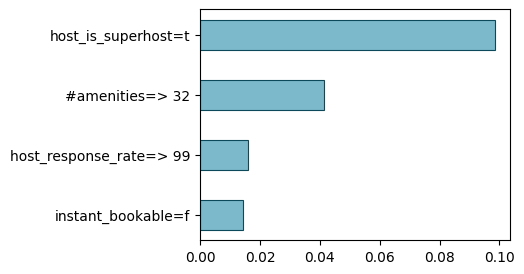

In [43]:
fp_details.plot_shapley_value(itemset)

In [44]:
start_time = time.time()
patterns_nr = fp_details.get_patterns(th_redundancy=0)
print(f'{round(time.time() - start_time, 2)} seconds')


3.81 seconds


In [45]:
try:
    start_time = time.time()
    
    gsv = fp_details.global_shapley_value()
    print(f'{round(time.time() - start_time, 2)} seconds')
except MemoryError:
    print("Memory limit exceeded!")

160.19 seconds


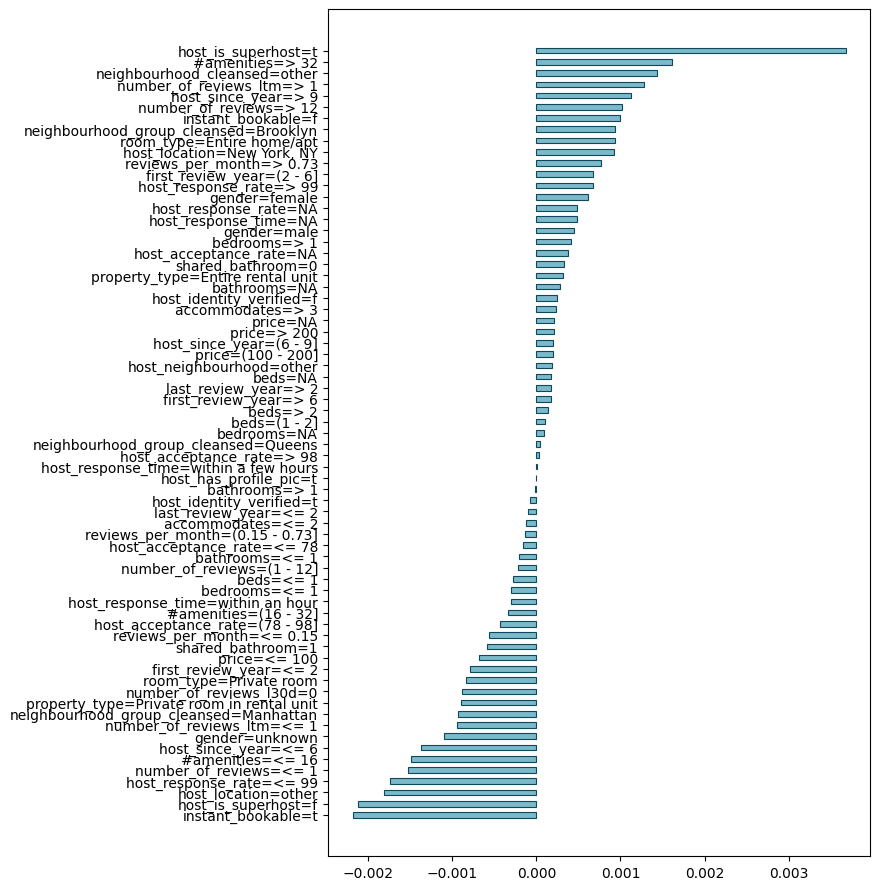

In [46]:
fp_details.plot_shapley_value(shapley_values=gsv, figsize=(7,11))  

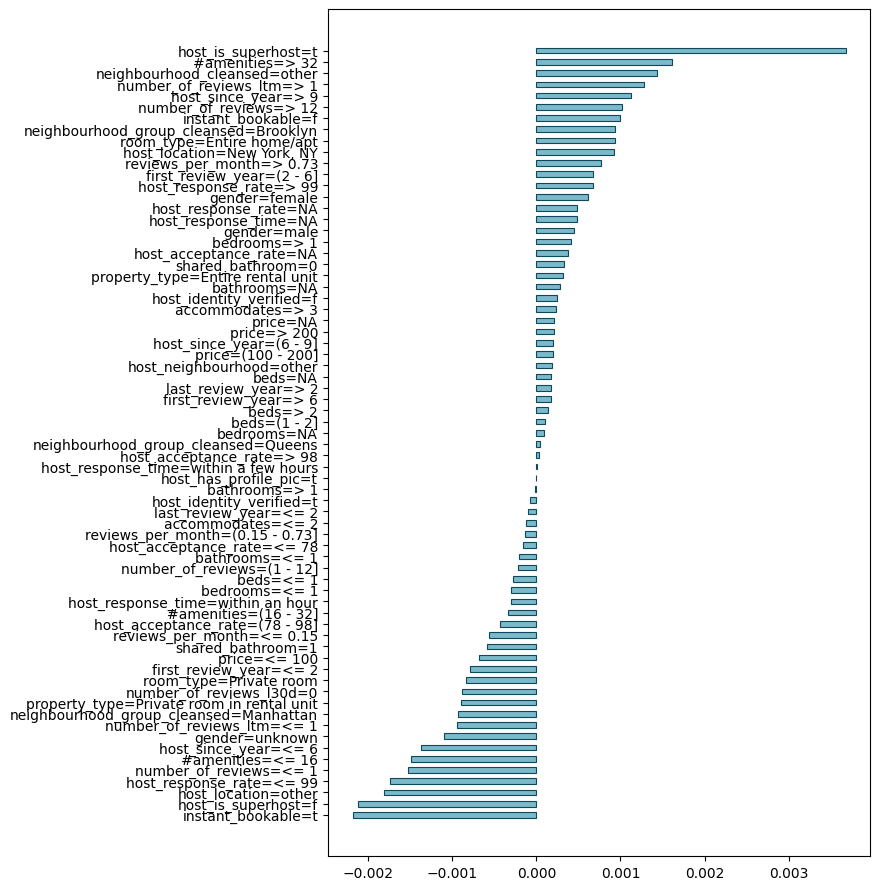

In [47]:
fp_details.plot_shapley_value(shapley_values=gsv, figsize=(7,11))  

In [48]:
individual_divergence = fp_details.patterns.loc[fp_details.patterns['length']==1][['itemset', f'{target_col}_div']].set_index('itemset').to_dict()[f'{target_col}_div']

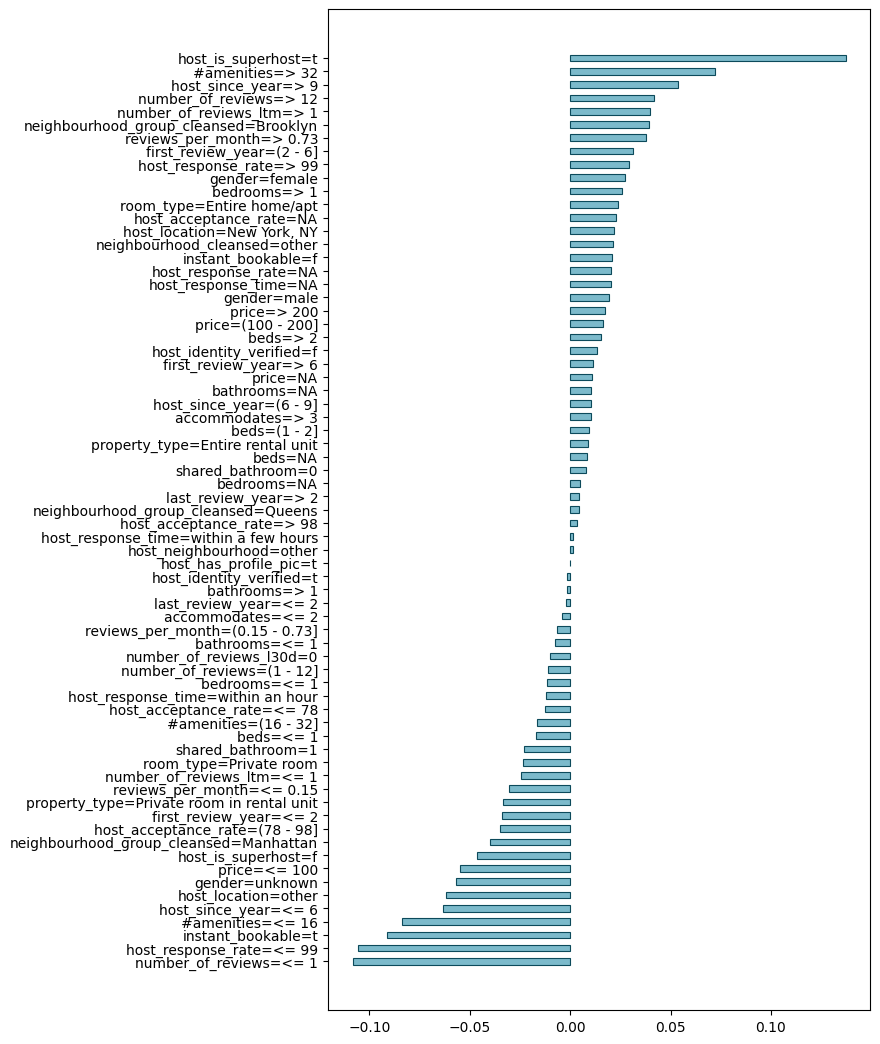

In [49]:
fp_details.plot_shapley_value(shapley_values=individual_divergence, figsize=(7,13))

In [50]:
dfi[dfi['instant_bookable']=='t'][target_col].mean(), dfi[dfi['instant_bookable']=='f'][target_col].mean(), dfi[target_col].mean()

(np.float64(4.634158945851349),
 np.float64(4.746054199772986),
 np.float64(4.72515210953425))

In [51]:
abbreviations={"host_is_superhost":"superhost", "number_of_reviews":"#reviews", \
              "neighbourhood_group_cleansed":"neigh_group", 
              "host_neighbourhood":"host_neigh",\
              "New York, New York, United States":"New York", 
              "apartment":"apt"}

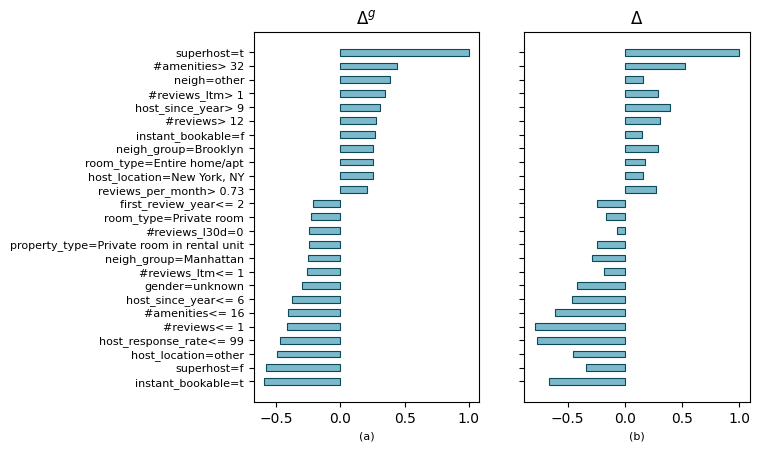

In [52]:
from utils import plot_comparison_ShapleyValues, normalize_max, abbreviate_dict

K=25
topK_global = {k:v for k,v in gsv.items() if k in sorted(gsv, key=lambda x: abs(gsv[x]))[::-1][:K]}
topK_indiv = {k:v for k,v in individual_divergence.items() if k in topK_global.keys()}

plot_comparison_ShapleyValues(normalize_max(abbreviate_dict(topK_global, abbreviations)),
                      normalize_max(abbreviate_dict(topK_indiv, abbreviations)),
                     title=[f"$\\Delta^g$", f"$\\Delta$"], \
                      labelsize=8, height=0.5, size_fig=(10,7),\
                     subcaption=True)
                     #save_fig=saveFig, 
                     #name_fig=f"{outDirGlobal}/{dataset_name}_FPR_shap_gl_compare_{min_sup}")
